# 🧹  Before WaveNet, a bit of cleaning 
We have finally made through the backprop! Congrats! Now, we are continuing our **ride** to reach at the GPT. And on this step, we will be making a *bit more complex* model, which will let us get more control over the dynamics of the learning.

 🧼 **But first** we will clean the code a bit more... let's do that now, without being lazy <br>
 Let's do it.
 

 *PS: I will stasy with the single special token as Andrej uses, to keep track of the losses, so instead of `<` and `>`, we will use only `.`*

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 1️⃣ Loading & creating the dataset

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# loading the dataset
with open("./names.txt", "r") as file:
    names = file.read().splitlines()

# total unique characters
characters = sorted(list(set(''.join(names))))

# Builind index-to-char and char-to-index
number_to_chr = {k:v for k, v in enumerate(["."] + characters)}
chr_to_number = {v:k for k, v in enumerate(["."] + characters)}

👉 Dataset creation

In [2]:
# This function will build the dataset and return the X, Y
# Used when we have multiple splits :)
block_size = 3
def build_dataset(shuffled_names):
    sot = chr_to_number["."]

    X = []
    y = []

    for name in shuffled_names: #FOR ALL NAMES
        window_chars = [sot] * block_size
        name = name + "."

        for ch in name:
            _3chars = ''.join(
                list(
                    map(lambda x:number_to_chr[x], window_chars)
                )) 
            ch_index = chr_to_number[ch]

            X.append(window_chars)
            y.append(ch_index)
            window_chars = window_chars[1:] + [ch_index]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

In [3]:
import random
random.seed(42)
random.shuffle(names) # In-place shuffling. No longer first word will be "emma"


train_idx = int(0.8 * len(names)) # 80%
val_idx = int(0.9 * len(names)) # 90% - 80% = 10%

Xtrain, ytrain = build_dataset(names[:train_idx])
Xval, yval = build_dataset(names[train_idx:val_idx])
Xtest, ytest = build_dataset(names[val_idx:])

print(f"* {Xtrain.shape = }\n* {Xval.shape = }\n* {Xtest.shape = }")

* Xtrain.shape = torch.Size([182625, 3])
* Xval.shape = torch.Size([22655, 3])
* Xtest.shape = torch.Size([22866, 3])


👉 What is in the training?

In [4]:
for x, y in zip(Xtrain[:20], ytrain[:20]):
    print(''.join(number_to_chr[ix.item()] for ix in x), "→", number_to_chr[y.item()])
    if y.item() == 0: print()

... → y
..y → u
.yu → h
yuh → e
uhe → n
hen → g
eng → .

... → d
..d → i
.di → o
dio → n
ion → d
ond → r
ndr → e
dre → .

... → x
..x → a
.xa → v
xav → i
avi → e


# 2️⃣ We "pytorchified" the code, remember?

## Creating a linear class 

In [6]:
class Linear:
    """
    This will be used to create a Linear Layer of `n_ins` and `n_outs`
    and also performs the matrix multiplication
    
    - Possible to enable/disable the bias
    - Automatically set the weights and initialize them with Kaiming
    """
    
    def __init__(self, n_ins, n_outs, bias=True):
        self.weight = torch.randn(n_ins, n_outs) / n_ins**0.5
        self.bias = torch.zeros(n_outs) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

## Creating a BatchNorm class 

In [7]:
class BatchNorm1d:
    """
    This will implement the whole batchnorm stuff that can later be added 
    with the linear layer.
    
    - Perform normalization
    - Keep track of the statistics of the batch "while" training "and while" evaluation
    - Distinction between training and evaluation/inference
    """
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """
        `eps`: Adds a small number in the denomenator while standardizing to
            avoid division by zero error
            
        `momentum`: Used in the calculation of the statistics while training
            to set the effect of how much of the std and mean to keep from the
            current batch. High momentum means learn more and visaversa.
        """
        
        self.dim = dim
        self.eps = eps
        self.momentum = momentum
        self.training = True # Will be explained later in a bit below.
        
        ### For scaling & shifting
        # Sacler will be called `gamma`
        # Shifter will be called `beta`
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        ### Keep track of running mean and variance for the inference!
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
        
    def __call__(self, x):   
        ### If `training` then calculate the mean and var 
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        ### If `not training` then use the running mean and var
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        ### Normalize!
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        ### Calculate the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

This code:
```python
if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * running_var + self.momentum * xvar
        return self.out
```

If it is not clear, don't worry. 
- Here we are simply calculating the mean and variance from the training and saving them so that later **while the inference** it can be used
- The way it is learnt is called "exponential smoothing average" or "EWMA". 

> 🤗 <br>I have made a comprehensive guide on exponential smoothing (EWMA) in my [time-series repository](https://github.com/AayushSameerShah/TimeSeries-Forecasting/blob/main/2.%20Exponential%20Smoothing%20and%20ETS/3.%20EWMA.ipynb) *(direct link to that topic)*.

## Creating a Tanh class 

In [8]:
class Tanh:
    """
    Just to calculate the `tanh`
    """
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [9]:
torch.manual_seed(42);

## 3️⃣ Creating a network (OLD WAY)

In [10]:
n_embd = 10
n_neurons = 200
vocab_size = len(number_to_chr) # 28

embeddings = torch.randn(vocab_size, n_embd)
layers = [
    Linear(n_embd * block_size, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    Linear(n_neurons, vocab_size), 
]

In [11]:
with torch.no_grad():
    # Scrutinizing - 1 effect: Make the outputs less confident
    layers[-1].weight *= 0.1 # the magic number ;)

parameters = [embeddings]
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


## Train!

In [12]:
import torch.nn.functional as F

In [13]:
epochs = 1_00_000
batch_size = 32
losses = []

for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[sample_idx], ytrain[sample_idx]
    
    # 1️⃣ Forward pass
    emb = embeddings[Xb] 
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # for better visualization 

      0/ 100000: 3.2966
  10000/ 100000: 2.2322
  20000/ 100000: 2.3166
  30000/ 100000: 2.1226
  40000/ 100000: 2.2524
  50000/ 100000: 2.3476
  60000/ 100000: 1.8864
  70000/ 100000: 1.9446
  80000/ 100000: 2.6730
  90000/ 100000: 2.1364


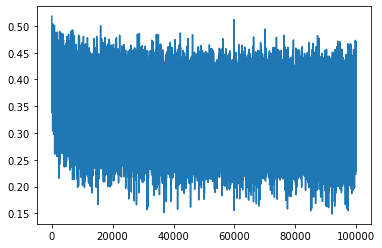

In [14]:
plt.plot(losses)

## Evaluate

In [15]:
for layer in layers:
    layer.training = False

In [16]:
@torch.no_grad() # NEW - Will disable the gradient tracking temproarily - for performance sake
def split_loss(split: str):
    x, y = {
        'train': (Xtrain, ytrain),
        'test': (Xtest, ytest),
        'val': (Xval, yval)
    }[split]
    
    emb = embeddings[x]
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    final_loss = F.cross_entropy(x, y)
    print(split.title(), ":\t", round(final_loss.item(), 5))

In [17]:
split_loss('train')
split_loss('val')
split_loss('test')

Train :	 2.12655
Val :	 2.15261
Test :	 2.15053


## Take inference

In [18]:
for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = embeddings[torch.tensor([context])]
        x = emb.view(-1, block_size * n_embd)
        for layer in layers:
            x = layer(x)
        logits = x
        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print(''.join(number_to_chr[i] for i in out))

jamelaxsuela.
reemethneliwiie.
merakiza.
ahyan.
fyja.
jayeshuylah.
eaj.
aton.
vajaia.
yidonna.
lareicarleise.
ilon.
imi.
eddel.
aajaevianai.
fenzeeya.
ikaisey.
tal.
abdaellarshia.
alimiamareemido.


## 4️⃣ Creating a network (NEW WAY)
Some little fixes, a more modular code.

### `1.` Fixing the chart 
A little fix, but notable.

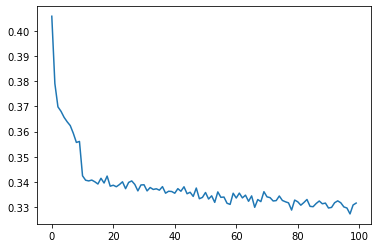

In [19]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1));

### `2.` Modulizing the Embedding

We have been working with these lines:
```python
n_embd = 10
n_neurons = 200
vocab_size = len(number_to_chr) # 28

embeddings = torch.randn(vocab_size, n_embd)
layers = [
    Linear(n_embd * block_size, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    Linear(n_neurons, vocab_size), 
]
```

**See**, we are progressively making our code more like the "lego" pieces which can be arranged together and can be used to build a higher structure, so all pieces should be *Manageable*.

We have the `embedding` layer, which is dangling differently, we need to modulize it.

In [20]:
class Embedding:
    """
    1. It will initialize the weights
    2. It is able to call the weights based on their index
    """
    def __init__(self, vocab_size, n_embd):
        self.weights = torch.randn(vocab_size, n_embd)
        
    def __call__(self, IX):
        self.out = self.weights[IX]
        return self.out
    
    def parameters(self):
        return [self.weights]

In [21]:
## This is an amazing BUT simple layer!

class Flatten:
    """
    It will act as a "concatenator" of the received embeddings
    of the sample characters.
    
    You know, `e, m, m` selected, and we want to use emb.view()?
    This line does that exactly!
    """
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

#### 👨‍💻 Modifying the code 

In [95]:
n_embd = 10
n_neurons = 200
vocab_size = len(number_to_chr) # 27

# [- DEL] embeddings = torch.randn(vocab_size, n_embd)
layers = [
    Embedding(vocab_size, n_embd), # [+ ADD]
    Flatten(),                     # [+ ADD]
    Linear(n_embd * block_size, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    Linear(n_neurons, vocab_size), 
]

In [96]:
for layer in layers:
    layer.training = False

In [97]:
with torch.no_grad():
    layers[-1].weight *= 0.1

# parameters = [embeddings]   # [- DEL] 
parameters = []
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [98]:
epochs = 10_000
batch_size = 32
losses = []

for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[sample_idx], ytrain[sample_idx]
    
    # 1️⃣ Forward pass
    # emb = embeddings[Xb]                  # [- DEL] 
    # x = emb.view(-1, block_size * n_embd) # [- DEL] 
    x = Xb                  # [+ ADD]
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # for better visualization 

      0/ 200000: 3.2974
  10000/ 200000: 2.4611
  20000/ 200000: 2.0884
  30000/ 200000: 2.0797
  40000/ 200000: 2.2941
  50000/ 200000: 2.3382
  60000/ 200000: 2.1325
  70000/ 200000: 2.1268
  80000/ 200000: 1.9920
  90000/ 200000: 2.1597
 100000/ 200000: 1.6820
 110000/ 200000: 2.2291
 120000/ 200000: 2.0857
 130000/ 200000: 2.1686
 140000/ 200000: 2.3218
 150000/ 200000: 2.2013
 160000/ 200000: 1.8858
 170000/ 200000: 1.7480
 180000/ 200000: 2.3042
 190000/ 200000: 2.3578


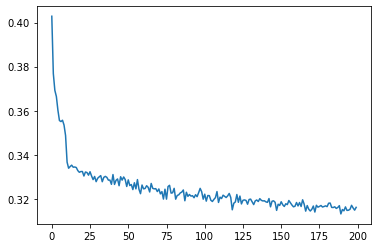

In [99]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1));

In [100]:
@torch.no_grad() # NEW - Will disable the gradient tracking temproarily - for performance sake
def split_loss(split: str):
    x, y = {
        'train': (Xtrain, ytrain),
        'test': (Xtest, ytest),
        'val': (Xval, yval)
    }[split]
    
    for layer in layers:
        x = layer(x)
    final_loss = F.cross_entropy(x, y)
    print(split.title(), ":\t", round(final_loss.item(), 5))

In [101]:
split_loss('train')
split_loss('val')
split_loss('test')

Train :	 2.07861
Val :	 2.12486
Test :	 2.12907


In [102]:
for layer in layers:
    layer.training = False

In [103]:
for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        x = torch.tensor([context])
        for layer in layers:
            x = layer(x)
        logits = x
        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print(''.join(number_to_chr[i] for i in out))

kem.
den.
nachrine.
win.
damone.
tegs.
delizani.
zehl.
sal.
mayen.
elziee.
malayvonni.
zhanani.
zikoselynn.
divia.
siro.
makriella.
bazlee.
maddope.
lakyleah.


# 🚢 Containers! 
Alright, enough training and old code reshaping. Now we are **getting serious**. We will use some serious things that you will see in the actual world. Let's see how.

- The container, **contains** or **stores** a bunch of layers, and the ***style*** to store these layers, is based on the type of the container. 
- Here we are using the `list` as the "so called container" but that is so open (in the `layers` variable).
- Since we are modulizing things, there should also be **a way** to do the same with these layers organization.

> 🏆 Mostly used container is **`sequential`** . Which does the linear, dense matrix multiplication as we did, and stores the layer in the "sequential"  fashion, *layers one-by-one*. 

In [106]:
class Sequential:
    """
    We will simply replace the explicit LIST keeping
    and FOR LOOPING for the forward pass, in this
    single class.
    
    This is very very neat thing to be done.
    """
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        parameters = []
        for layer in self.layers:
            for p in layer.parameters():
                parameters.append(p)
        return parameters

## Updated code...

In [112]:
n_embd = 10
n_neurons = 200
vocab_size = len(number_to_chr) # 27

layers = [
    Embedding(vocab_size, n_embd), 
    Flatten(),                     
    Linear(n_embd * block_size, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    Linear(n_neurons, vocab_size), 
]

model = Sequential(layers) ### WE WILL CALL `MODEL` ✨

In [113]:
with torch.no_grad():
    # layers[-1].weight *= 0.1     # [- DEL] 
    model.layers[-1].weight *= 0.1 # [+ ADD]

# parameters = []                 # [- DEL] 
# for layer in layers:            # [- DEL] 
#    for p in layer.parameters(): # [- DEL] 
#        parameters.append(p)     # [- DEL] 
parameters = model.parameters()   # [+ ADD]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [114]:
epochs = 10_000
batch_size = 32
losses = []

for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[sample_idx], ytrain[sample_idx]
    
    # 1️⃣ Forward pass
    # [- DEL] x = Xb
    # [- DEL] for layer in layers:
    #            x = layer(x)
    logits = model(Xb) # [+ ADD]
    loss = F.cross_entropy(logits, Yb) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # for better visualization 

      0/  10000: 3.2977


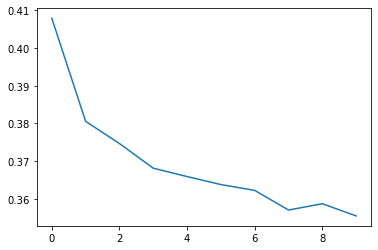

In [115]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1));

In [118]:
@torch.no_grad() # NEW - Will disable the gradient tracking temproarily - for performance sake
def split_loss(split: str):
    x, y = {
        'train': (Xtrain, ytrain),
        'test': (Xtest, ytest),
        'val': (Xval, yval)
    }[split]
    
    logits = model(x)
    final_loss = F.cross_entropy(logits, y)
    print(split.title(), ":\t", round(final_loss.item(), 5))

In [119]:
split_loss('train')
split_loss('val')
split_loss('test')

Train :	 2.27653
Val :	 2.28524
Test :	 2.28415


> NOTE: We have only trained the model for 10,000 epochs... just to test whether the code's working.

In [120]:
# for layer in layers:     # [- DEL]
for layer in model.layers: # [+ ADD]
    layer.training = False

In [121]:
for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        x = torch.tensor([context])
        logits = model(x)
        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print(''.join(number_to_chr[i] for i in out))

anrian.
aal.
aswlynnal.
katyliutiel.
sza.
abosaemizo.
anvi.
auliat.
kaivvuer.
anni.
aadfenahnika.
ner.
nuy.
gardnee.
gere.
annasero.
sharzira.
xmel.
tree.
nynle.


Yo! 🔥

# 🌊 WaveNet! 
Yo! We will take a look at this beast, later in the next book 😊 <br>
I would like to keep the code "modulized" so... but worry not, we will use the same classes used here, in the next book.

See you there in a bit!